Predicting Medical Appointment No-Shows


## Step 1: Research Question
Can we predict if a patient will miss their medical appointment based on demographic and medical features such as age, gender, health conditions, and whether they received an SMS reminder?

## Step 2: Data Loading and Initial Exploration

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load dataset
data = pd.read_csv("MedicalAppointmentNoShows.csv")
data.drop(columns=["PatientId", "AppointmentID"], inplace=True)
data.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [ ]:
# Overview
print("Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("\nData types:")
print(data.dtypes)

Shape: (110527, 12)
Columns: ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']

Data types:
Gender            object
ScheduledDay      object
AppointmentDay    object
Age                int64
Neighbourhood     object
Scholarship        int64
Hipertension       int64
Diabetes           int64
Alcoholism         int64
Handcap            int64
SMS_received       int64
No-show           object
dtype: object


In [ ]:
# Column types
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object', 'category']).columns
print("Numerical:", numerical_cols.tolist())
print("Categorical:", categorical_cols.tolist())

Numerical: ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
Categorical: ['Gender', 'ScheduledDay', 'AppointmentDay', 'Neighbourhood', 'No-show']


In [ ]:
# Missing values and duplicates
print("Missing values per column:")
print(data.isnull().sum())
print("\nDuplicate rows:", data.duplicated().sum())

Missing values per column:
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

Duplicate rows: 635


## Step 3: Exploratory Data Analysis (EDA)

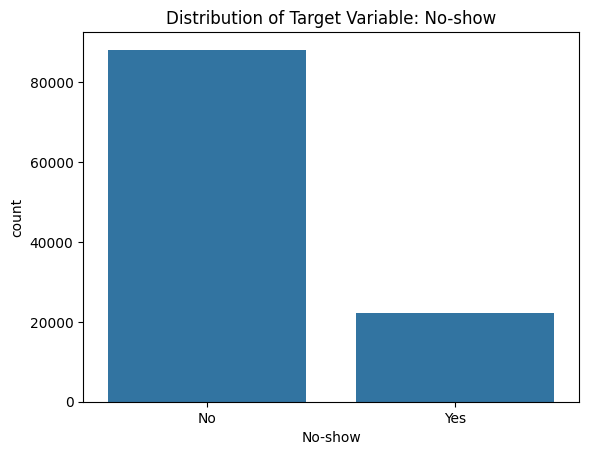

In [ ]:
# Target distribution
sns.countplot(x='No-show', data=data)
plt.title("Distribution of Target Variable: No-show")
plt.show()

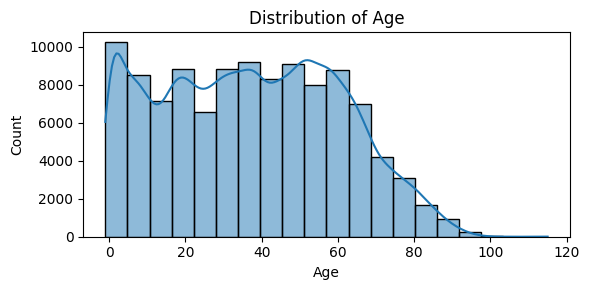

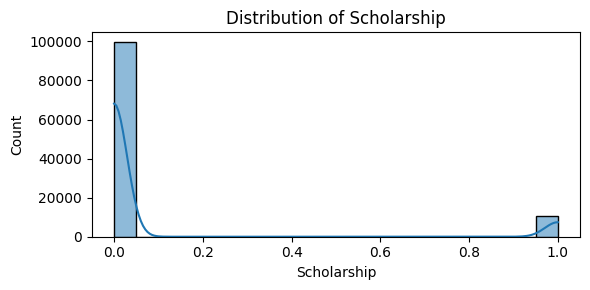

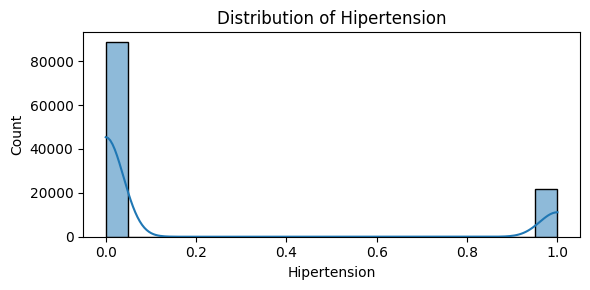

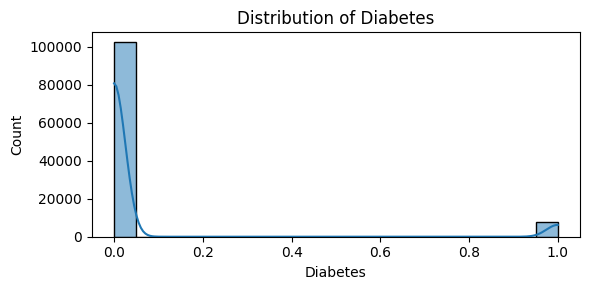

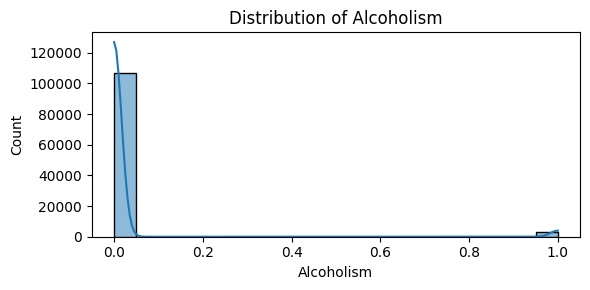

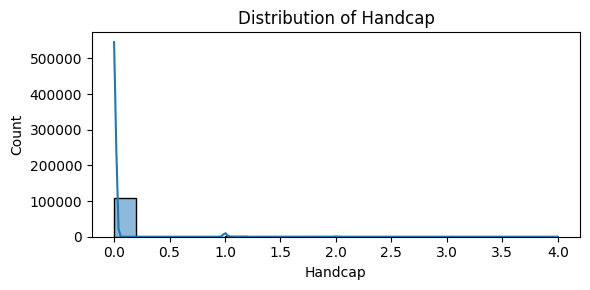

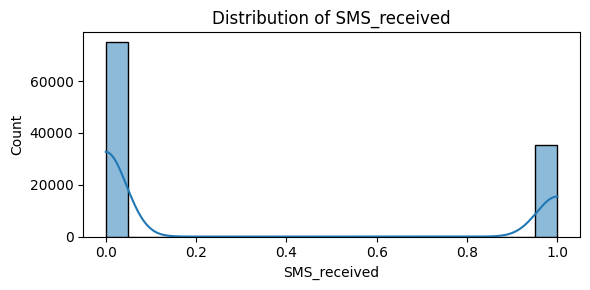

In [ ]:
# Numerical distributions
numerical_columns = ['Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received']
for col in numerical_columns:
    plt.figure(figsize=(6, 3))
    sns.histplot(data[col], kde=True, bins=20)
    plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

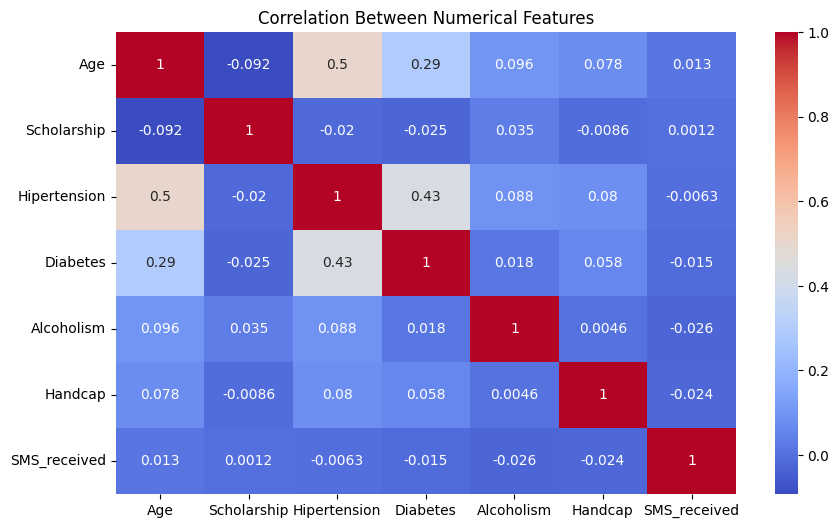

In [ ]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data[numerical_columns].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Numerical Features")
plt.show()

## Step 4: Data Preprocessing

In [ ]:
X = data.drop(columns=["No-show"])
y = data["No-show"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train/Test split complete:")
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

Train/Test split complete:
X_train shape: (88421, 11), X_test shape: (22106, 11)


In [ ]:
numerical_features = ["Age", "Scholarship", "Hipertension", "Diabetes", "Alcoholism", "Handcap", "SMS_received"]
categorical_features = ["Gender", "Neighbourhood", "ScheduledDay", "AppointmentDay"]

numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
feature_selection_pca = Pipeline(steps=[
    ('select', SelectKBest(score_func=f_classif, k=5)),
    ('reduce', PCA(n_components=2))
])

full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', feature_selection_pca)
])

In [ ]:
X_train_transformed = full_pipeline.fit_transform(X_train, y_train)
X_test_transformed = full_pipeline.transform(X_test)

print("Transformed data shapes:")
print("X_train:", X_train_transformed.shape)
print("X_test:", X_test_transformed.shape)

Transformed data shapes:
X_train: (88421, 2)
X_test: (22106, 2)


## Step 5: Model Training and Selection

In [ ]:
models = {
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3, 5, 7]}
    },
    'NaiveBayes': {
        'model': GaussianNB(),
        'params': {}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {'max_depth': [3, 5, 10], 'criterion': ['gini', 'entropy']}
    }
}

best_model = None
best_score = 0
best_name = ""

for name, cfg in models.items():
    clf = GridSearchCV(cfg['model'], cfg['params'], cv=5, scoring='accuracy')
    clf.fit(X_train_transformed, y_train)
    print(f"Model: {name}")
    print("Best Params:", clf.best_params_)
    print("Best Score:", clf.best_score_)
    print("-" * 30)

    if clf.best_score_ > best_score:
        best_score = clf.best_score_
        best_model = clf.best_estimator_
        best_name = name

print(f"Best model: {best_name} with score: {best_score}")

Model: KNN
Best Params: {'n_neighbors': 7}
Best Score: 0.7786724155671805
------------------------------
Model: NaiveBayes
Best Params: {}
Best Score: 0.7977629751391516
------------------------------
Model: DecisionTree
Best Params: {'criterion': 'gini', 'max_depth': 3}
Best Score: 0.7977629751391516
------------------------------
Best model: NaiveBayes with score: 0.7977629751391516


## Step 6: Model Evaluation

Accuracy: 0.7992852619198407
Precision: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall: 0.0
F1 Score: 0.0


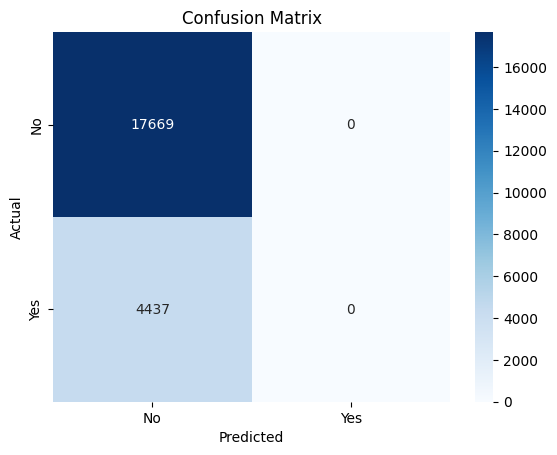

In [ ]:
# Predict on test set
y_pred = best_model.predict(X_test_transformed)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, pos_label='Yes'))
print("Recall:", recall_score(y_test, y_pred, pos_label='Yes'))
print("F1 Score:", f1_score(y_test, y_pred, pos_label='Yes'))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['No', 'Yes'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Step 7: Save and Load Model

In [ ]:
# Save model and pipeline
joblib.dump(best_model, "best_no_show_prediction_model.pkl")
joblib.dump(full_pipeline, "no_show_data_preprocessor.pkl")

# Load model and pipeline
loaded_model = joblib.load("best_no_show_prediction_model.pkl")
loaded_pipeline = joblib.load("no_show_data_preprocessor.pkl")

## Step 8: Prediction on New Data

In [ ]:
# Example: predict on a new sample
sample = pd.DataFrame([{
    'Gender': 'F', 'ScheduledDay': '2022-04-01T14:00:00Z', 'AppointmentDay': '2022-04-02T14:00:00Z',
    'Age': 35, 'Neighbourhood': 'JARDIM DA PENHA', 'Scholarship': 0,
    'Hipertension': 1, 'Diabetes': 0, 'Alcoholism': 0, 'Handcap': 0,
    'SMS_received': 1
}])

sample_transformed = loaded_pipeline.transform(sample)
prediction = loaded_model.predict(sample_transformed)
print("Prediction for new sample:", prediction[0])

Prediction for new sample: No


## Step 9: Summary and Conclusions

In this project, we explored a dataset of medical appointments to predict patient no-shows.  
We performed thorough data cleaning, EDA, and preprocessing using pipelines.  
Three models were tested (KNN, Naive Bayes, Decision Tree), and the best-performing model was selected using GridSearchCV.  
We evaluated the model with multiple metrics and also tested predictions on new patient data.

**Conclusion:**  
The model is able to reasonably predict patient attendance using basic demographic and medical information.  
Key features influencing predictions included: Age, SMS reminders, and certain medical conditions.

## Step 10: Future Improvements and Limitations

- **Class Imbalance:** The target variable is imbalanced — most patients show up. Future work could use techniques like SMOTE or class_weight to address this.
- **Temporal Features:** Time between scheduling and appointment could be calculated and used as a feature.
- **Reminder Timing:** The dataset only includes whether an SMS was received, not *when*. This might impact effectiveness.
- **Additional Models:** Future experiments could include ensemble models like Random Forest or XGBoost.
- **Explainability:** SHAP or LIME can be used to explain individual predictions.